# Explorative analysis
- summary
    - check for uniformly distributed features
    - features types
    - variance
- missingness (MAR?)
- multi-correlation (VIF)
- labels = diagnoses
- for context of features - read [paper](https://journals.plos.org/digitalhealth/article?id=10.1371/journal.pdig.0000170)

# Import cleaned features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb

In [2]:
features = pd.read_pickle("data/rwanda/features.pickle")

## Summary

In [22]:
# summarize features by computing min, max, mean, std etc.
# NOTE: features need to be transformed to numerics on order to be considered by python's built in function: describe,
numericalized_features = features.apply(lambda x : x.replace({ # gives more insight to features if turned to numerics before summary
    "female": 1, "male": 0,
    "Yes": 1, "No": 0, 
    "Absent": 0, "Present": 1, 
    # special categorical symptoms need to be manually numericalized based on domain knowledge so that ordinal scale of original feature is respected 
    "< 38 °C": 0, ">= 38°C": 1, # for BC - Axillary temperature - 7823
    "< 2 weeks": 0,  ">= 2 weeks": 1, # for S176 - Cough duration (days) - 7731 categorical
    "more than -2 z-score": 0, "-2 z-score": 1, "less than -2 z-score": 2, # for BC7 - Weight for age (z-score) - 8434 categorical and BC95 - Weight for height - 7451 categorical 
    '> - 2 z-score': 0, "- 2 z-score": 1, '< -2 z-score': 2, # for "BC61 - MUAC for age z-score - 7839 categorical"
    '>= 12.5 cm': 0, '>= 11.5 < 12.5 cm': 1, '< 11.5 cm' : 2, # for BC - MUAC in cm - 7833 categorical
    'Accepted': 1, 'Manually added': 1, 'Rejected': 0, # for DF130 - fever without source: presumed bacterial infection - 30602 and DF129 - fever without source: presumed viral illness
    'Negative': 0, 'Positive': 1, # for malaria feature})
    'Feeding well': 0, 'Not feeding well': 1, 'Not feeding at all': 2, # for "S180 - How is the infant feeding currently? - 7516"
    'Movement without stimulation': 0, 'Movement only when stimulated': 1, 'No movement even when stimulated': 2, # for "PE125 - Observation of movement - 8388"
    '< 4 days': 0, '>= 4 days < 7 days': 1, '>= 7 days < 14 days': 2, '>= 14 days': 3, # for "S42 - Duration of fever (days) - 7819 categorical"
    'Normal': 0, 'Pathologic': 1, # for "A55 - Urinary dipstick - 7648"
    '<3': 0, '>=3': 1, '>=4': 2, '>=5': 3, '>=6': 4, # for "S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical"
  })).astype(float)
summary_features = numericalized_features.describe().transpose().reset_index().rename(columns={"index": "feature"}) # bring into better format

# get features type according to python
summary_features["dtype"] = [features[feature].dtype for feature in summary_features["feature"]]

# capture unique values --> are there anomalies?
summary_features["unique_values"] = [features[feature].dropna().unique() for feature in summary_features["feature"]]

# get number of unique values (NAN not counted)
summary_features["number_unique_values"] = [len(features_unique_values) for features_unique_values in summary_features["unique_values"]]

# determine type of each feature: binary, categorical (if dtype is object and the feature is not binary or if feature) or continues (if dtype is float)
# NOTE: 16 is chosen as threshold for determining features as categorical so that feature patient_age is regarded as categorical
summary_features["type"] = ["binary" if len(features[feature].dropna().unique()) <= 2 else "categorical" if features[feature].dtype == "object" else "continues" for feature in summary_features["feature"]]

# compute share of NAN values for each feature
summary_features["share_nan_values_in_%"] = (features.shape[0] - summary_features["count"]) / features.shape[0] * 100

# only keep two digits of decimal numbers
summary_features = summary_features.round(2)

summary_features

,feature,count,mean,std,min,25%,50%,75%,max,dtype,unique_values,number_unique_values,type,share_nan_values_in_%
0,patient_age,47806.0,3.27,3.55,0.0,0.0,2.0,5.0,15.0,float64,"[0.0, 2.0, 1.0, 6.0, 4.0, 5.0, 3.0, 9.0, 8.0, ...",16,continues,0.00
1,patient_gender,47806.0,0.53,0.50,0.0,0.0,1.0,1.0,1.0,object,"[male, female]",2,binary,0.00
2,PE212 - Respiratory rate (breaths/min) - 8469,16888.0,34.78,10.86,5.0,28.0,35.0,40.0,144.0,float64,"[36.0, 34.0, 38.0, 37.0, 40.0, 32.0, 18.0, 35....",125,continues,64.67
3,S39 - Cough - 7817,32003.0,0.55,0.50,0.0,0.0,1.0,1.0,1.0,object,"[Yes, No]",2,binary,33.06
4,PE18 - Chest indrawing - 7811,17436.0,0.02,0.13,0.0,0.0,0.0,0.0,1.0,object,"[No, Yes]",2,binary,63.53
5,S180 - How is the infant feeding currently? - ...,1401.0,0.09,0.31,0.0,0.0,0.0,0.0,2.0,object,"[Feeding well, Not feeding well, Not feeding a...",3,categorical,97.07
6,S46 - Convulsions in present illness - 8355,32891.0,0.00,0.03,0.0,0.0,0.0,0.0,1.0,object,"[No, Yes]",2,binary,31.20
7,BC - Axillary temperature - 7823 categorical,35027.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0,object,"[< 38 °C, >= 38°C]",2,binary,26.73
8,PE125 - Observation of movement - 8388,1396.0,0.02,0.18,0.0,0.0,0.0,0.0,2.0,object,"[Movement without stimulation, Movement only w...",3,categorical,97.08
9,S96 - Unable to drink or breastfeed - 7871,31510.0,0.00,0.05,0.0,0.0,0.0,0.0,1.0,object,"[No, Yes]",2,binary,34.09


In [26]:
# store summary as pickle for dashboard
summary_features_for_dash = summary_features[['feature', 'type', 'count', 'share_nan_values_in_%', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary_features_for_dash.columns = ['Feature', 'Type', 'Count', 'Share missing values in %', 'Mean', 'Std', 'Min', '25% quantile', 'Median', '75% quantile', 'Max']
summary_features_for_dash.to_pickle("data/dash/summary_features.pickle")

In [27]:
# for report print features as latex table
print(summary_features_for_dash.to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format)) 

\begin{tabular}{llrrrrrrrrr}
\toprule
                                           Feature &        Type &   Count &  Share missing values in \% &  Mean &  Std &  Min &  25\% quantile &  Median &  75\% quantile &   Max \\
\midrule
                                       patient\_age &   continues & 47806.0 &                        0.0 &   3.3 &  3.5 &  0.0 &           0.0 &     2.0 &           5.0 &  15.0 \\
                                    patient\_gender &      binary & 47806.0 &                        0.0 &   0.5 &  0.5 &  0.0 &           0.0 &     1.0 &           1.0 &   1.0 \\
     PE212 - Respiratory rate (breaths/min) - 8469 &   continues & 16888.0 &                       64.7 &  34.8 & 10.9 &  5.0 &          28.0 &    35.0 &          40.0 & 144.0 \\
                                S39 - Cough - 7817 &      binary & 32003.0 &                       33.1 &   0.6 &  0.5 &  0.0 &           0.0 &     1.0 &           1.0 &   1.0 \\
                     PE18 - Chest indrawing - 7811 & 

C:\Users\sidla\AppData\Local\Temp\ipykernel_2228\738836564.py:2: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



## Missingness

In [8]:
# missingness of features
missingness_features = pd.DataFrame({"feature":features.columns})

# compute number of nan values per feature 
missingness_features["number_nan_values"] = [sum(features[feature].isna()) for feature in missingness_features["feature"]]

# compute share of nan values per feature
missingness_features["share_nan_values"] = missingness_features["number_nan_values"]/features.shape[0]

# sort based on share_nan_values
missingness_features = missingness_features.sort_values(by="share_nan_values", ascending=False)

missingness_features.head()

,feature,number_nan_values,share_nan_values
30,S81 - Urethral discharge - 7810,47798,0.999833
31,S79 - Genital lesion - 7867,47777,0.999393
29,S74 - Abnormal vaginal discharge - 8377,47566,0.994980
24,PE218 - Unexplained bleeding - 8107,47026,0.983684
20,A55 - Urinary dipstick - 7648,46924,0.981550


In [9]:
# boxplot of share of nan values in feautures
fig = px.box(missingness_features, y="share_nan_values", title="Share of NAN values in features", labels={"share_nan_values" : "Share NAN values"})
fig.show()

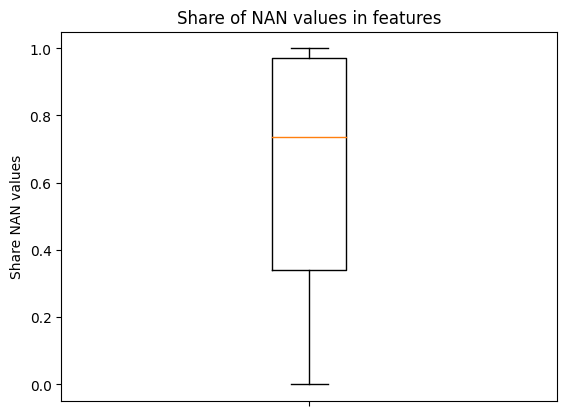

In [10]:
# boxplot of share of nan values in feautures
plt.boxplot(missingness_features["share_nan_values"])
plt.title("Share of NAN values in features")
plt.ylabel("Share NAN values")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.show()

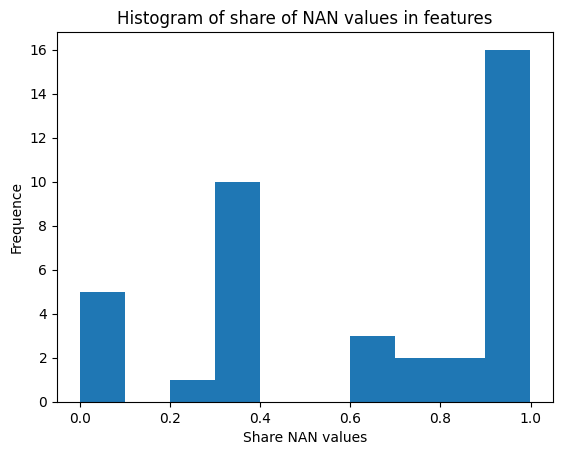

In [11]:
# distribution of share of nan values in features
plt.hist(missingness_features["share_nan_values"])
plt.title("Histogram of share of NAN values in features")
plt.ylabel("Frequence")
plt.xlabel("Share NAN values")
plt.show()

### Missingness pattern in features - MCAR, MAR or MNAR?
- MCAR = Missing completely at random = missingness of values of a certain feature depends not on any features
- MAR = Missing at random = missingness of values of a certain feature depends on given values of other features (e.g. for MAR: feature1 is missing features when there are high values of feature2 given).
- MNAR = Missing not at random = missingness of values of a certain feature depends on its own missing values (e. g. symptom1 misses features whenever symptom1 would have low values. However, these low values are never observed.)

[source](https://www.theanalysisfactor.com/missing-features-mechanism/)

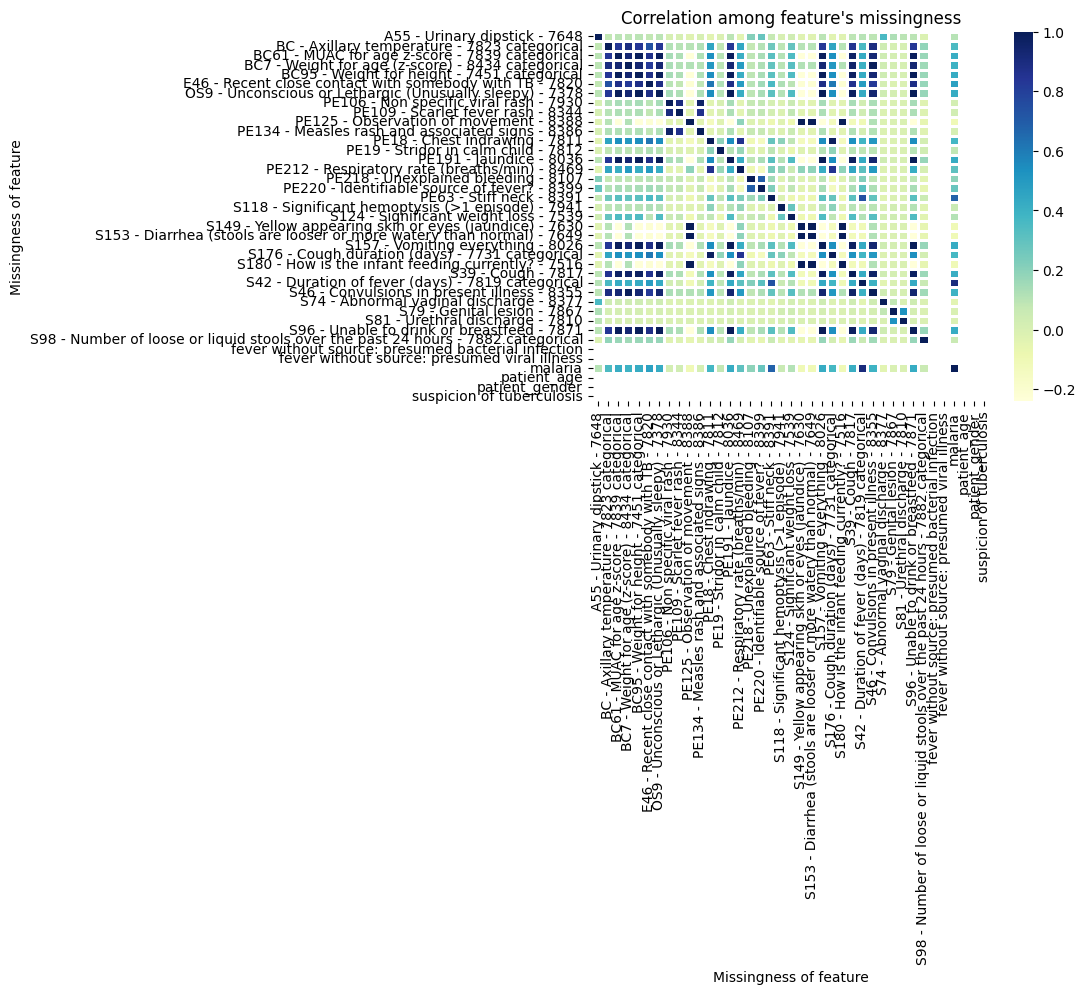

In [12]:
# are features missing when other features are missing --> MAR
# shadow matrix: whenever original features holds nan value the missingness matrix will have a 1 at this element position else 0
shadow_matrix_features = features.isna()*1

# check if missingness of features correlates with other features' missingness
missingness_correlation = shadow_matrix_features.corr() # drop rows and columns which entirely consist of nan: add this as code:.dropna(how = "all").dropna(how = "all", axis = 1

# sort x and y axis for upcoming plot
missingness_correlation = missingness_correlation.sort_index(axis=0)
missingness_correlation = missingness_correlation.sort_index(axis=1)

# visualize correlation of features' missingness
missingness_correlation_heatmap = sb.heatmap(missingness_correlation, cmap="YlGnBu", annot=False, xticklabels=True, yticklabels=True, linewidths=1)
plt.title("Correlation among feature's missingness")
plt.xlabel("Missingness of feature")
plt.ylabel("Missingness of feature")

# displaying heatmap
plt.show()

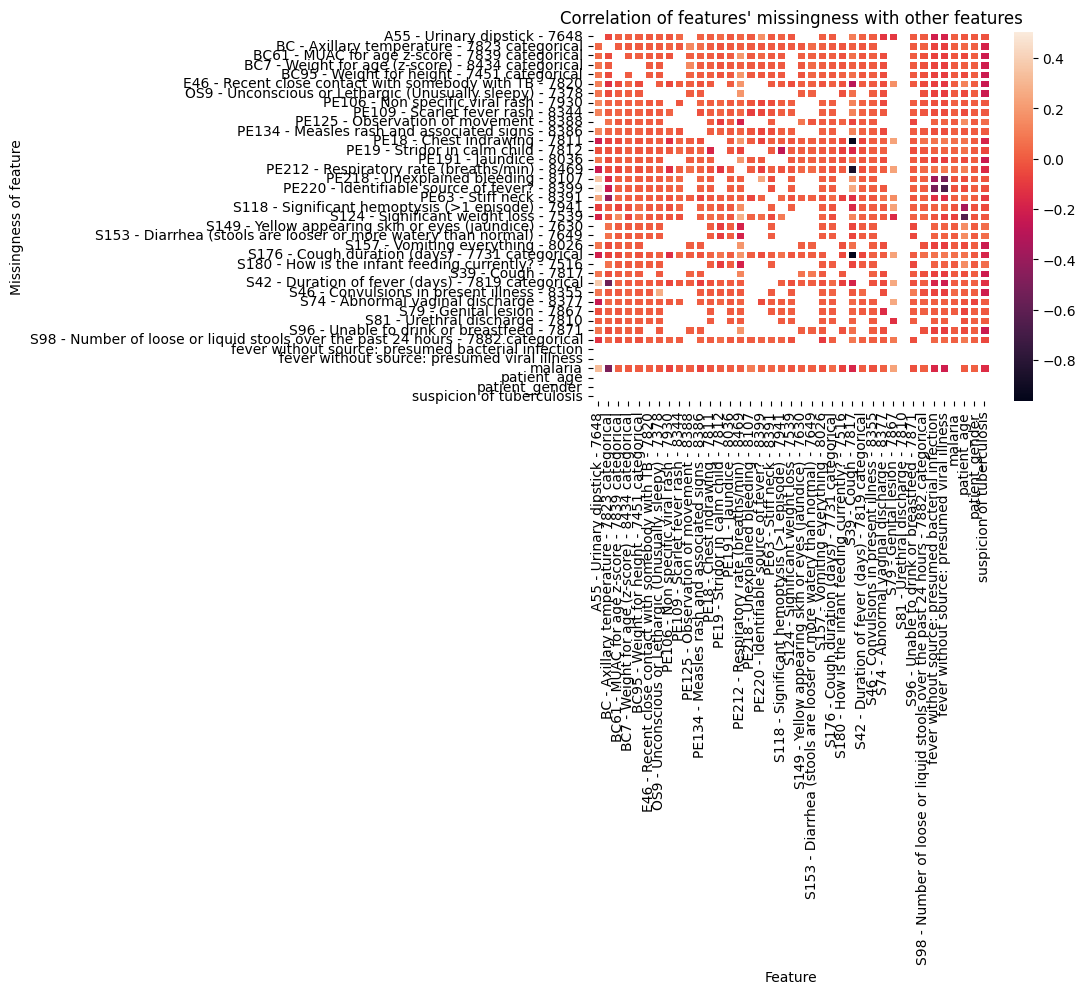

In [14]:
# check for missing at random through correlation of missingness of a feature with every other feature
# TODO run lgbm classifier and use --> shap values
mar_check_results = []
for missing_feature in shadow_matrix_features.columns:
    corr = []
    exp_var = []
    for exp_feature in features.columns:
        corr.append(shadow_matrix_features[missing_feature].corr(numericalized_features[exp_feature]))
        exp_var.append(exp_feature)
    temp = pd.DataFrame({"missing_feature": missing_feature, "explaining_feature":exp_var, "corr_coef":corr})
    mar_check_results.append(temp)
mar_check = pd.concat(mar_check_results)

fig = sb.heatmap(mar_check.pivot("missing_feature", "explaining_feature", "corr_coef").sort_index(axis=0).sort_index(axis=1), annot=False, xticklabels=True, yticklabels=True, linewidths=1) # cmap="YlGnBu"
plt.title("Correlation of features' missingness with other features")
plt.ylabel("Missingness of feature")
plt.xlabel("Feature")

# displaying heatmap
plt.show()

In [15]:
# if missingness of feature correlates with any feature the missingness is MAR (note: correlation is assumed when absolute of correralation coeffiicent is above 0.5) 
mar_check["interesting"] = 0  
mar_check.loc[np.absolute(mar_check["corr_coef"]) > 0.5,"interesting"] = 1
mar_check.groupby("missing_feature")["interesting"].sum().reset_index(name="number_explaining_features")

,missing_feature,number_explaining_features
0,A55 - Urinary dipstick - 7648,0
1,BC - Axillary temperature - 7823 categorical,0
2,BC61 - MUAC for age z-score - 7839 categorical,0
3,BC7 - Weight for age (z-score) - 8434 categorical,0
4,BC95 - Weight for height - 7451 categorical,0
5,E46 - Recent close contact with somebody with ...,0
6,OS9 - Unconscious or Lethargic (Unusually slee...,0
7,PE106 - Non specific viral rash - 7930,0
8,PE109 - Scarlet fever rash - 8344,0
9,PE125 - Observation of movement - 8388,0


#### Conclusion - missingness pattern
- what is bad for clustering?
- Only few features' missingness can be explained by other features. These features are regarded as MAR.
- considering the context, the features is surely MNAR because if a symptom is having NAN values it means that the CDSS did not consider the symptom be present or of high value. This legitimizes imputing NAN values based on domain knowledge.
- However due to the high share of NAN values in the features every clustering result is assessed if the missing values could explain it.

## Multi-correlation (VIF)

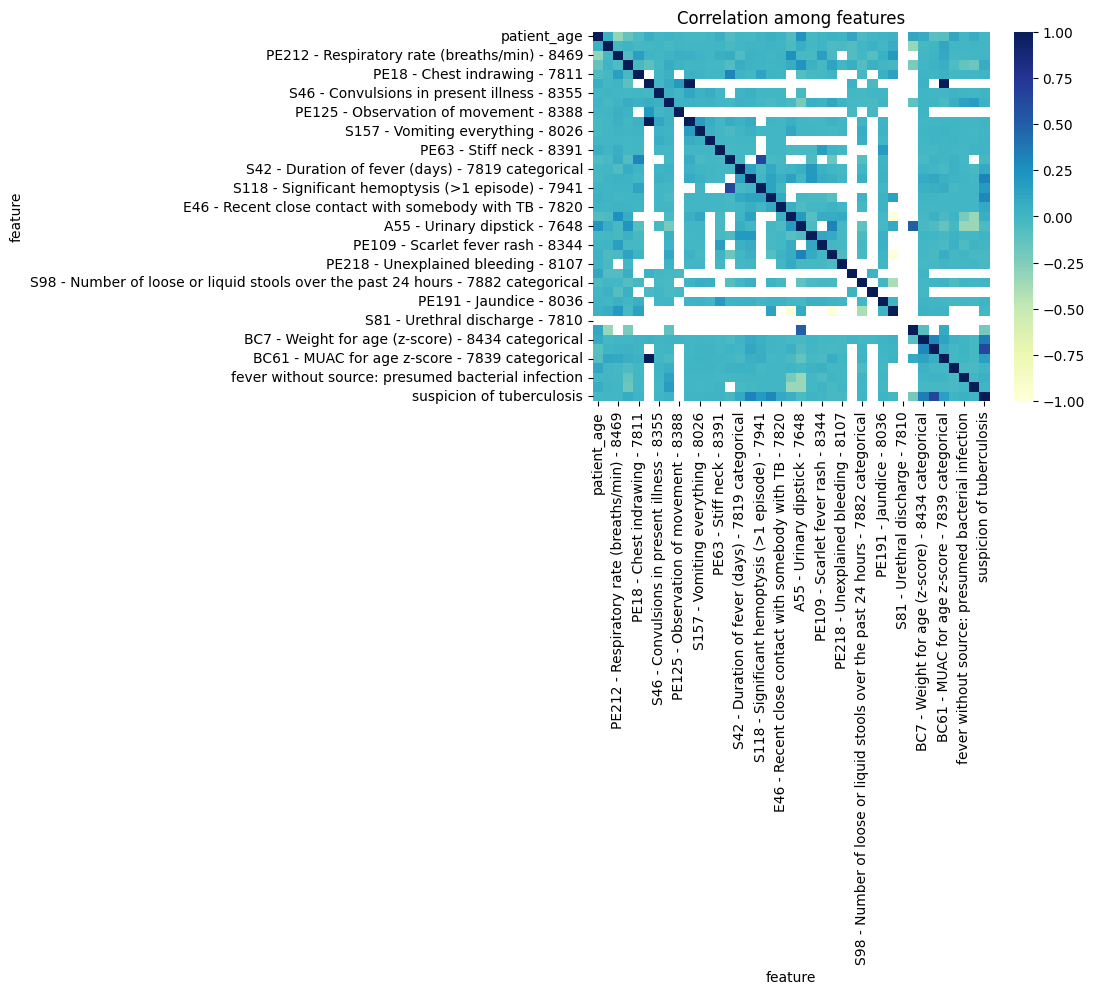

In [16]:
# visualize correlation of features
feature_correlation_heatmap = sb.heatmap(numericalized_features.corr(), cmap="YlGnBu", annot=False)
plt.title("Correlation among features")
plt.xlabel("feature")
plt.ylabel("feature")

# displaying heatmap
plt.show()

In [17]:
# check for multicollinearity: is given if VIF (= variance inflation factor) is high (usually if vif > 3) source: https://www.investopedia.com/terms/v/variance-inflation-factor.asp#:~:text=A%20variance%20inflation%20factor%20(VIF)%20is%20a%20measure%20of%20the,in%20a%20multiple%20regression%20model.
"""from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.featuresFrame()
vif['Features'] = numericalized_features.columns
vif['VIF'] = [variance_inflation_factor(numericalized_features.values, i) for i in range(numericalized_features.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif"""

'from statsmodels.stats.outliers_influence import variance_inflation_factor\nvif = pd.featuresFrame()\nvif[\'Features\'] = numericalized_features.columns\nvif[\'VIF\'] = [variance_inflation_factor(numericalized_features.values, i) for i in range(numericalized_features.shape[1])]\nvif[\'VIF\'] = round(vif[\'VIF\'], 2)\nvif = vif.sort_values(by = "VIF", ascending = False)\nvif'

## Labels = diagnoses
As we are doing unsupervised learning there are no label. However, it is of interest to look at the desired labels whicha re the diagnoses made by the CDSS. There are 169 diagnoses wo we reduce it to the 10 most common ones and try to cluster symptoms and signs for them.

In [19]:
# import preprocessed diagnoses
diagnoses = pd.read_pickle("data/rwanda/diagnoses.pickle")

In [20]:
# top 10 most common diagnoses
top10_diagnoses = diagnoses.sum().sort_values(ascending=False).to_frame().reset_index().head(10)
top10_diagnoses.columns = ["diagnosis", "number_consultations"]
print("share of top 10 diagnoses:", top10_diagnoses["number_consultations"].sum()/diagnoses.shape[0], "= share of consultations being diagnosed with at least one of the top 10 diagnoses")
fg = px.bar(top10_diagnoses, x="diagnosis", y="number_consultations", title="Top 10 given diagnoses", labels={"number_consultations" : "Number consultations", "diagnosis": "Diagnosis"})
fg.show()

share of top 10 diagnoses: 0.6952474584780153 = share of consultations being diagnosed with at least one of the top 10 diagnoses


In [21]:
# distribution "number of top 10 diagnoses per consultation" 
number_top10_diagnoses_per_consultation = diagnoses[top10_diagnoses["diagnosis"]].sum(axis=1).value_counts().to_frame().reset_index()
number_top10_diagnoses_per_consultation.columns = ["Number top 10 diagnoses per consultation", "count"]
fg = px.bar(number_top10_diagnoses_per_consultation, x="Number top 10 diagnoses per consultation", y="count", title="Distribution of 'Number of top 10 diagnoses per consultation'", labels={"count": "Count"} )
fg.show()